In [1]:
import cantera as ct    # import cantera
import math             # import math (sqrt, exp, etc.)
from scipy.integrate import solve_ivp  # solves ODE (initial value problems)
import scipy.integrate as integrate
import matplotlib.pyplot as plt      # does matlab-like plotting
import numpy as np                    # does a bunch of array stuff

In [2]:
from scipy.integrate._ivp.rk import OdeSolver  # this is the class we will monkey patch

from tqdm import tqdm

### monkey patching the ode solvers with a progress bar

# save the old methods - we still need them
old_init = OdeSolver.__init__
old_step = OdeSolver.step

# define our own methods
def new_init(self, fun, t0, y0, t_bound, vectorized, support_complex=False):

    # define the progress bar
    self.pbar = tqdm(total=t_bound - t0, unit='ut', initial=t0, ascii=True, desc='IVP')
    self.last_t = t0
    
    # call the old method - we still want to do the old things too!
    old_init(self, fun, t0, y0, t_bound, vectorized, support_complex)


def new_step(self):
    # call the old method
    old_step(self)
    
    # update the bar
    tst = self.t - self.last_t
    self.pbar.update(tst)
    self.last_t = self.t

    # close the bar if the end is reached
    if self.t >= self.t_bound:
        self.pbar.close()


# overwrite the old methods with our customized ones
OdeSolver.__init__ = new_init
OdeSolver.step = new_step

In [3]:
gasAmbient = ct.Solution("gri30.yaml")

In [4]:
Tamb = 300 # kelvin
Pamb = 101325 # Pa
gasAmbient.TPX = Tamb, Pamb, {'O2':1, 'N2':3.76}

In [5]:
# definishions 
B = 0.082 #m        # bore (diameter of piston)
L = 0.14554 #m    # connection rod length
S = 0.0904 #m      # stroke length
Cr = 16.7      # compression ratio
intake_rise_factor = 20 
intake_open_angle = 0 # deg
intake_close_angle = 220 # deg
exhaust_rise_factor = 20
exhaust_open_angle = 0
exhaust_close_angle = 720
intake_max_area = 0.001478684 
exhaust_max_area = 0.00078581

Ap = (np.pi/4)*(B**2)                                                                       # piston area equation
Vd = S*Ap                                                                                # displacement volume 
Vc = Vd/(Cr - 1)                                                                         # clearance volume
R = S/2                                                                                  # length of crank arm

theta = 0          # initial crank angle

N = 2500              # engine speed

In [6]:
def intake_valve_area(theta):
    theta_shift = 360.
    t = (theta + theta_shift) % 720
    to_rel = intake_open_angle + theta_shift
    tc_rel = intake_close_angle + theta_shift
    
    y = intake_max_area*0.5*(
    np.tanh((t - to_rel)/intake_rise_factor) -
    np.tanh((t - tc_rel)/intake_rise_factor))
    return y

def exhaust_valve_area(theta):
    theta_shift = 360.
    t = (theta + theta_shift) % 720
    to_rel = exhaust_open_angle - theta_shift
    tc_rel = exhaust_close_angle - theta_shift
    
    y = exhaust_max_area*0.5*(
    np.tanh((t - to_rel)/exhaust_rise_factor) -
    np.tanh((t - tc_rel)/exhaust_rise_factor))
    return y

In [7]:
def getVolume(theta): 
    volume = Vc + Ap*(L + R + (R*math.cos(theta + np.pi)) - ((L**2)-((R**2)*(math.sin(theta + np.pi))**2))**0.5)  # volume eq
    return volume

In [8]:
def get_mdot(theta, density, temperature, gas, direction):    
    # direction: 0 = inlet, else = outlet
    if direction == 0:     # inlet
        p0 = gasAmbient.P
        pb = gas.P
        Rc = gasAmbient.cp_mass - gasAmbient.cv_mass
        A = intake_valve_area(np.degrees(theta))
        γ = gasAmbient.cp / gasAmbient.cv 
        temperature = gasAmbient.T
    else:                  # outlet
        p0 = gas.P
        pb = gasAmbient.P
        Rc = gas.cp_mass - gas.cv_mass
        A = exhaust_valve_area(np.degrees(theta))
        γ = gas.cp / gas.cv
    
    A = 0
    M = min(1, (((2*(max((((p0/pb)**((γ-1)/γ))-1),0)))/(γ-1))**0.5))                                 #mach number
    lamb = (M*(γ**0.5))*((1+(((γ-1)/2)*(M**2)))**(-((γ+1)/(2*(γ-1)))))                          #lambda
    mf = ((p0)/((Rc*temperature)**0.5))*lamb                                                 #mass flux
    mdot = A*mf*2   #multiplied by 2 becuase of 2 valves?                                    #mass flow rate through valve
    return mdot

In [9]:
def CV_Reactor_RHS(t,y,gas):
    # t = time
    # y = the solution vector: y[0] = temperature, y[1:nSpecies] = mass fractions
    
    dy = np.zeros(np.size(y)) # initialize the RHS vector
    
    T = y[0];
    density = y[1];
    massFrac = y[2:];
    
    tdot = ((2*np.pi)/60)*N
    theta = tdot*t
    volume = getVolume(theta)
    mdot_in = get_mdot(theta, density, T, gas, 0) 
    mdot_out = get_mdot(theta, density, T, gas, 1) 
    hout = gas.enthalpy_mass
    hin = gasAmbient.enthalpy_mass    # j/kmol
    mdot = (mdot_in - mdot_out) 
    Qdot = 0
    cv_mix = gas.cv_mass
    u_mix = gas.int_energy_mass
    mass = density * volume
    Yi_in = gas.Y
    
    gas.set_unnormalized_mass_fractions(massFrac)
    gas.TD=T, density 
    
    
    mws  = gas.molecular_weights                 # get the species MW_i
    wdot = gas.net_production_rates * mws      # get the species MASS production rate
    ui = gas.partial_molar_int_energies / mws      # get the species internal energy on a MASS basis
                                                             
        
    dV_dt = tdot*Ap*R*math.sin(theta + np.pi)*(-1 + R*math.cos(theta + np.pi)/np.sqrt(L**2-(R*math.sin(theta + np.pi))**2))
    dW_dt = gas.P * dV_dt
    
    # Governing equations
    dYdt = ((volume/mass)*wdot)-((massFrac/mass)*mdot)+((1/mass)*(mdot_in*Yi_in))-((1/mass)*(mdot_out*massFrac))
    dTdt = (-dW_dt + (hin*mdot_in) - (hout*mdot_out) - (mass*np.sum(ui*dYdt)) - (mdot*u_mix))/(mass*cv_mix)
    drho_dt = ((1/volume) * mdot) - ((density / volume) * dV_dt)
    
    # stuff the temperature and mass fraction time derivatives into an array
    dy[0] = dTdt
    dy[1] = drho_dt
    dy[2:] = dYdt
    
    return dy

In [10]:
def integrate_CV_reactor(gas, tEnd,atol=1.e-10, rtol=1.e-8):

    # set the initial conditions for the reactor
    y =  np.zeros(gas.n_species+2) 
    y[0] = gas.T
    y[1] = gas.density_mass
    y[2:] = gas.Y

    # solve the ODEs for the reactor.  This is equivalent to ode15s in Matlab.
    soln = integrate.solve_ivp(fun=lambda t, y: CV_Reactor_RHS(t,y,gas), 
                               t_span=[0,tEnd],y0=y,method='BDF',rtol=rtol,atol=atol);
    return soln

In [11]:
gas = ct.Solution("gri30.yaml")

In [12]:
# The initial conditions are based on the gas state.

gas.TPX = 300, 101325, {'He':1}

print(gas.density_mass, gas.P)

# now integrate the ODEs
soln = integrate_CV_reactor(gas, 30.)

0.2167562193855446 101325.0


IVP: 100%|#########################################################################| 30.0/30.0 [01:20<00:00,  2.69s/ut]


In [13]:
temp_index = 0
OH_index = gas.species_index('OH') + 2 
H2O_index = gas.species_index('H2O') + 2
CO2_index = gas.species_index('CO2') + 2
CH4_index = gas.species_index('CH4') + 2
O2_index = gas.species_index('O2') + 2

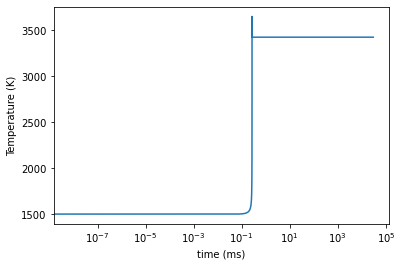

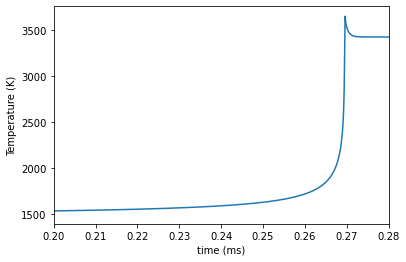

In [14]:
# Now plot the solution.  Note: Cantera works in SI units, but I convert to ms in the line below. 
plt.semilogx(soln.t*1000, soln.y[temp_index,:])
plt.xlabel('time (ms)')
plt.ylabel('Temperature (K)')
plt.show()


# The first plot isn't very useful... even on a semilogx-scale... Lets zoom in to where the action is. 
plt.plot(soln.t*1000, soln.y[temp_index,:])
plt.xlim(.20, .28)
plt.xlabel('time (ms)')
plt.ylabel('Temperature (K)')
plt.show()

    